In [1]:
%run "../../shared/utilz_image_proc.ipynb"

# 1. Test function calls

In [2]:
## Test Video capture with callback to process for identify contours on objects
def find_largest_as_doc(img_in, tfact=0.02, athresh=1000, logit=False):
    img = img_in.copy()
    if logit:
        print(f'START@find_largest_as_doc callback' )
    ## a. preprocess mask 
    img_edgez = cv2_preprocess_edges( img , dil_iterz=2)
    
    ## b. fetch contours & get largest object 
    contz, _ = cv2.findContours(img_edgez, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE )     
    max_area, biggest_obj = 0, None        
    for c in contz:
        a = cv2.contourArea( c )
        if a > athresh:
            peri = cv2.arcLength(c, True )
            appx = cv2.approxPolyDP(c, tfact*peri, True)            
            if len(appx) == 4 and a > max_area: ## is a rect and is larger
                biggest_obj = appx
                max_area = a
    
    if logit:
        print(f'@find_largest_as_doc callback --- drawing bounding box')
        
    # c. draw bounding box on identified document 
    if not biggest_obj is None:
        x, y, w, h = cv2.boundingRect( biggest_obj )
        img = cv2.rectangle( img, (x, y), (x+w, y+h), (200,0,255), 3)
    
    if logit:
        print(f'FINSHED@find_largest_as_doc callback')
    
    return img
    
cv2_video_capture( 0 , 
                  title='Tester Largest Item', 
                  img_handler=find_largest_as_doc, 
                  logit=True)

@cv2_video_capture: Starting 'Tester Largest Item' with img_handler as <function find_largest_as_doc at 0x7f3b01b01a70>


# 2. QRCode and BarCode Scanner
- `pyzbar` library
    - Read code message
    - Find location of code in frame

In [3]:
## Library for decoding scanner content 
from pyzbar.pyzbar import decode


In [4]:
# ip = "https://www.eurekalert.org/multimedia/pub/web/36930_web.jpg"
# img, _ = fetch_image( ip )
# plot_image(img)

In [5]:
## Example decode barcode
# ip = 
ipz = [
    "https://cdn.ttgtmedia.com/rms/misc/qr_code_barcode.jpg",
    "https://www.eurekalert.org/multimedia/pub/web/36930_web.jpg",  
    "https://arifdiyanto.files.wordpress.com/2015/11/qrcodeuk.gif", 
    "https://previews.123rf.com/images/bobnevv/bobnevv1711/bobnevv171100059/89044460-barcode-and-qr-code-set-collection-various-black-bar-codes-qr-codes-isolated-on-white-background-vec.jpg",
    "https://static2.bigstockphoto.com/9/2/3/large2/329386597.jpg",
]

qrbarcode_imagez = fetch_imagez_dict(ipz)

qrbarcode_imagez.keys()

# grid_plot_images( 
#     [ x[0] for x in qrbarcode_imagez.values()], 
#     list(qrbarcode_imagez.keys()),
#     nc=2, logit=False)

dict_keys(['Image # 0', 'Image # 1', 'Image # 2', 'Image # 3', 'Image # 4'])

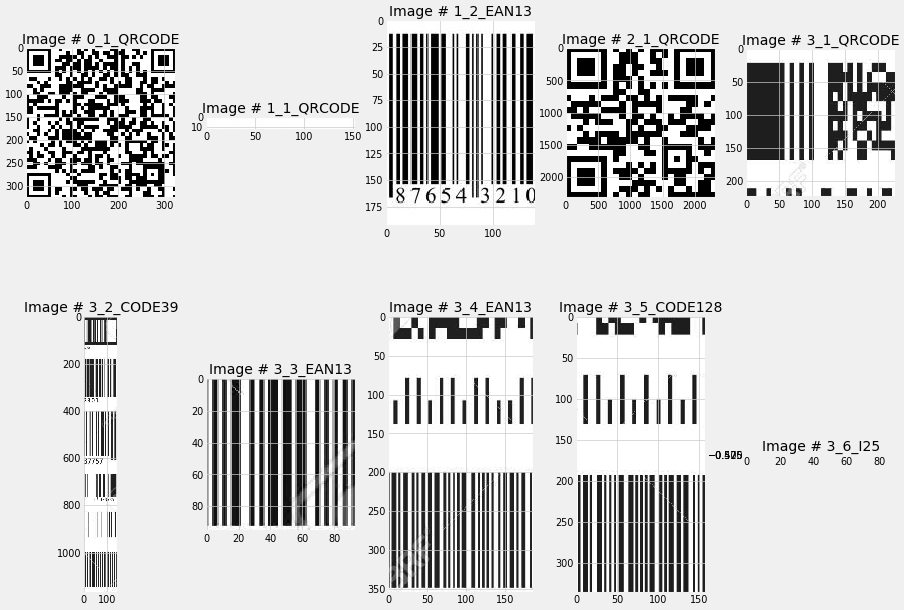

In [6]:
## Decode it << decode returns an array
findz = []
for key, img in qrbarcode_imagez.items():
    img = img[0] #cv2_preprocess_edges( img[0] )
#     findz.append( (f"{key}_prep", img) )
    for i, c in enumerate( decode(img) ):
#         print(f"<{i+1}>. {key}\n{c}" )
#         print( f"\tType: \t{c.type}")
#         print( f"\tData: \t{c.data.decode('utf-8')}")
        #print("\n")        
        x, y, w, h = c.rect
        findz.append( (f'{key}_{i+1}_{c.type}', img[x:x+w, y:y+h]) )
        
grid_plot_images(
    [bc[1] for bc in findz ], 
    [bc[0] for bc in findz ],
    nc=5, logit=False
)      

In [7]:
def handle_capture_frame(frame, logit=False):
    for qrbar in decode(frame):
#         print(qrbar)
        xi, yi, wi, hi = qrbar.rect
        xdat = qrbar.data.decode('utf-8')

        mp, bp = 20, 5
        lbl_bx_col = (20, 150, 0)
        lbl_col = (100, 10, 255)

        # box using the rect 
        frame = cv2.rectangle(
            frame, 
            (xi-bp,yi-mp-bp), (xi+wi+bp, yi+hi+bp), 
            lbl_bx_col, 2)
        # label 
        frame = cv2.rectangle(
            frame, 
            (xi-bp,yi-mp-bp), (xi+wi+bp, yi), 
            lbl_bx_col, cv2.FILLED
            )
        frame = cv2.putText(frame, 
                f'{xdat}',
               (xi, yi-bp), 
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 
                0.6, lbl_col, 1) 

        #TODO: why not in this version
#         # box using the polygon << so works even on rotation of the barcode. Is better
#         poly = qrbar.get('polygon', None)
#         if poly:
#             pts = np.array( [ poly ], np.int32)
#             pts = pts.reshape( (-1, 1, 2) )
#             frame = cv2.polylines(
#                 frame, 
#                 pts,  True, 
#                 lbl_col, 3)
        
    return frame

In [8]:
src_id=0
title='QRCode/BarCode Scanner'
width=640
height=480
intensity=150
logit=False
img_handler = handle_capture_frame

# def code_scanner_capture(src_id=0, title='QRCode/BarCode Scanner', width=640, height=480, intensity=150, logit=False):    
if logit:
    print(f"@cv2_video_capture: Starting '{title}' with img_handler as {img_handler}" ) 

cap = cv2.VideoCapture( src_id ) 
cap.set(3, width) ##width is id 3
cap.set(4, height) ##height is id 4
cap.set(10, intensity)

while cap.isOpened(): ## go frame by frame
    success, frame = cap.read()
    if success:            
        ## Process = draw bounding box on barcode and put data text
        frame = img_handler(frame, logit)
        cv2.imshow( title, frame)
    if cv2.waitKey(30) & 0xFF == 27: ##ESC  # 1 == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


False

False

False

In [9]:
# code_scanner_capture(0)

# 3. OCR Grader

In [10]:
# ip = "https://pyimagesearch.com/wp-content/uploads/2016/10/omr_test_01.png"
ip = "https://pyimagesearch.com/wp-content/uploads/2016/10/omr_finding_bubbles.jpg"
img, gimg = fetch_image( ip )
# grid_plot_images( [img, gimg])

new image shape = (230, 205, 3)


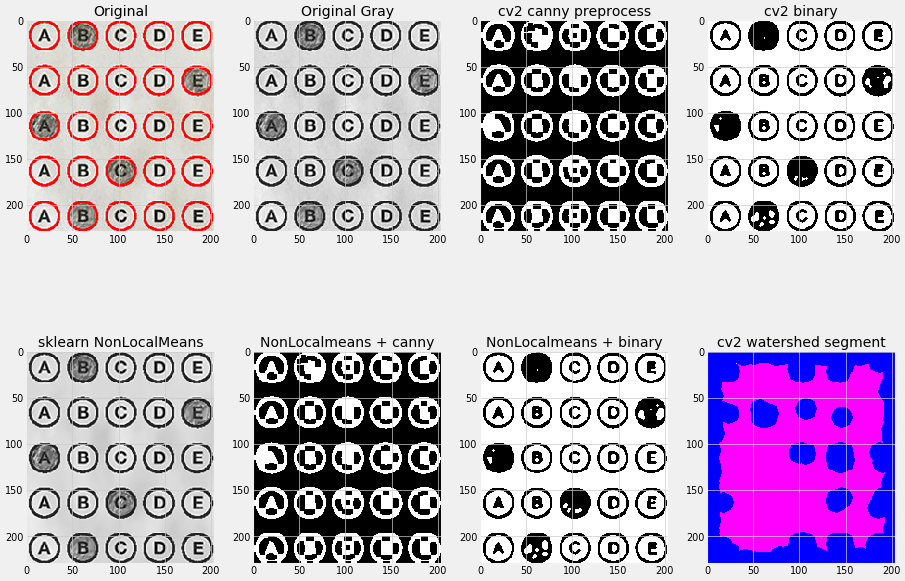

In [11]:
## resize Image and detect edgez
full_sheet_img = img.copy()
m = 100
img = img[m:-m-70, m+10:-m*7//8-2]
print(f'new image shape = {img.shape}')

gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


imgW, imgH = 700, 700
def show_preprocess_image(img, gimg):
    imagez = [img]
    labelz = ['Original']
    
    imagez.append(gimg)
    labelz.append('Original Gray')
    
    imagez.append( cv2_preprocess_edges(gimg, dil_iterz=1) )
    labelz.append( 'cv2 canny preprocess')
    
    imagez.append( clean_prepare_binary(gimg) )
    labelz.append( 'cv2 binary' )    
    
    nlm = nonlocalmeans_clean(gimg).astype(np.uint8)
    imagez.append( nlm )
    labelz.append( 'sklearn NonLocalMeans' )    
    
    imagez.append( cv2_preprocess_edges(nlm, dil_iterz=1) )
    labelz.append( 'NonLocalmeans + canny')
    
    
    imagez.append( clean_prepare_binary(nlm) )
    labelz.append( 'NonLocalmeans + binary' )
    
    _, ws = watershed_segment(img, gimg)
    imagez.append( ws )
    labelz.append( 'cv2 watershed segment' )
    watershed_segment
    
    grid_plot_images(
        imagez,
        labelz, 
        nc = 4,
        logit=False
        )
    
show_preprocess_image(img, gimg)

In [12]:
### ---- using non-local-means and binary 
import string 
choicez = list(string.ascii_uppercase)[:5]

img_prep = clean_prepare_binary( nonlocalmeans_clean(gimg).astype(np.uint8) )

def is_acceptable_rectangle(contour, athresh):
    a = cv2.contourArea( contour )
    res = False
    if a > athresh:
        p = cv2.arcLength(contour, True)
        appx_corners = cv2.approxPolyDP( contour, 0.02*p, True)
#         print(f"rect corners = {len(appx_corners)}")
        if len(appx_corners) >= 4 and len(appx_corners) < 10:
            res = True
    return res 

## redundant??
def get_rect_corner_points(contour):    
    p = cv2.arcLength(contour, True)
    return cv2.approxPolyDP( contour, 0.02*p, True)
    

def find_marked_bubbles():
    pass

def grade_scorecard(mask_img, out_img, mscheme, area_thresh=1000):
    r_color, p_color, c_color = (10, 10, 255), (200, 10, 10), (10, 200, 10)
    out = out_img.copy()    
    contz, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # a. grab the target answer and score areaz
    target_contourz = []
    for c in contz:
        if( is_acceptable_rectangle(c, area_thresh) ):
            target_contourz.append( c )
            cv2.drawContours( out, c, -1, r_color, 10) #default contour
    
    # b. sort from largest to smallest and select E.G. top 2 largest as answer and score areaz
    target_contourz = sorted( target_contourz, key=cv2.contourArea, reverse=True)
    
    # c. operate
#     print( f"Working on {len(target_contourz)} boxes")
    rowz_imgz = []       
    bubblez = []
    for c in target_contourz[0:1]:
        ## i. identify points 
        cornerz = get_rect_corner_points(c)
        x, y, w, h = cv2.boundingRect( c )
        out = cv2.drawContours( out, c, -1, r_color, 10) #default contour
        out = cv2.rectangle(out, (x,y), (x+w, y+h), r_color, 3 ) #outline rect
        out = cv2.drawContours( out, cornerz, -1, c_color, 30) #rect cornerz
        
        ## ii. warp:: REF: doc scanner code
        
        ## iii. thresholding if not already done at mask 
        
        ## iv. detect marked bubbles per row
        rowz_imgz = np.vsplit(mask_img, 5)    
        for q, row in enumerate(rowz_imgz):
            p_ans = 0
            col = np.hsplit(row, 5)
            p_ans = np.argmin([cv2.countNonZero( opt) for opt in col] )
            bubblez.append( p_ans )
            
        ## v. Grade it        
        grade = (np.array( bubblez) == np.array(mscheme)).mean()
#         print( f'Grade={grade} <<<< @{bubblez} Vs {mscheme}' )
        
        ## vi. plot
        nq, na = 5, 5
        sw = out.shape[1]//nq
        sh = out.shape[0]//na
        for i, ans in enumerate(bubblez):
            correct_ans = mscheme[i]
            xi, yi, ci = sw*ans, sh*i, sw*(correct_ans)
            pa, ca = r_color, c_color
            if ans == correct_ans:
                pa = c_color
            # a. mark provided answer
            _ = cv2.rectangle(out_img, (xi, yi), (xi+sw, yi+sh-5), pa, 2 )
            # b. mark correct answer
            _ = cv2.rectangle(out_img, (ci, yi), (ci+sw, yi+sh-5), ca, 3 )
        
        
    return out_img, grade # out, bubblez

In [19]:
# full_sheet_img[m:-m-70, m+10:-m*7//8-2] = np.dstack( (gimg, gimg, gimg))
# plot_image( c )

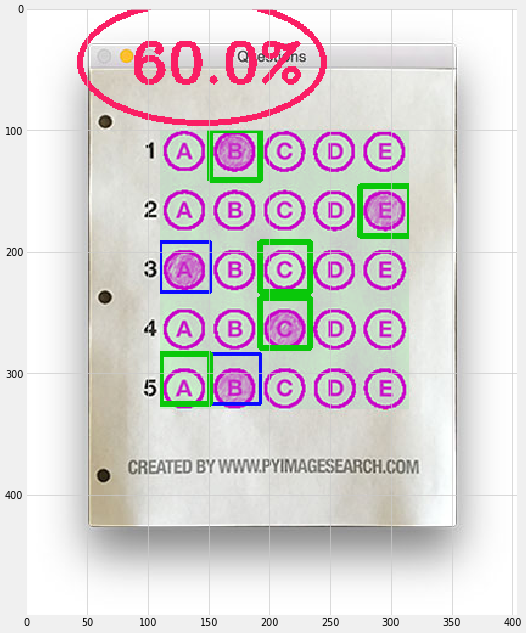

In [13]:
# a. score 
idx_marking_scheme = [1, 4, 2, 2, 0]
def update_mark_sheet(mscheme=idx_marking_scheme):
    simg = img.copy()
    simg[:, :,  0] = 200
    simg[:, :,  2] = 200
    sheet, score = grade_scorecard( img_prep , simg, mscheme)
    # b. update graded sheet 
    output_img = full_sheet_img.copy()
    output_img[m:-m-70, m+10:-m*7//8-2] = sheet
    # c. indicate grade
    r_color = (250, 30, 100)
    gx, gy, gr = output_img.shape[1]//4, 60, 50
    _ = cv2.ellipse(output_img, (gx+gr*7//8, gy-gr//3), (gr*2, gr), 0, 0, 360, color=r_color, thickness=3 )        
    _ = cv2.putText(output_img, 
                    f'{score*100}%',
                   (gx-15,gy), 
                    cv2.FONT_HERSHEY_COMPLEX, 
                    1.5, r_color, 3)
#     print(f"Marking Scheme = { ', '.join(marking_scheme)}") # <<<< { ', '.join([choicez[i] for i in idx_marking_scheme])}" )
    return output_img

plot_image( update_mark_sheet(), logit=False ) 

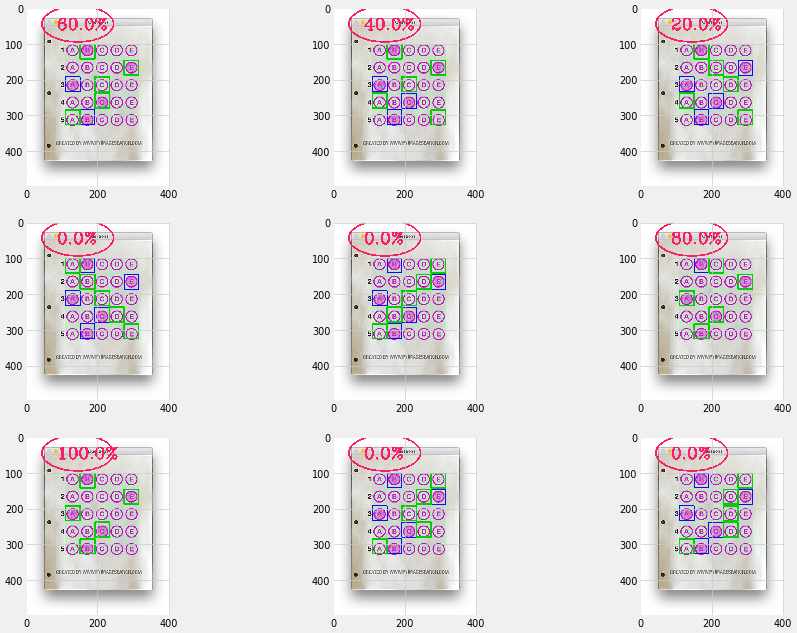

In [14]:
g_idx_marking_scheme = [
    idx_marking_scheme,
    [1, 4, 2, 0, 4],
    [1, 2, 3, 0, 4],
    [0, 1, 2, 3, 4],
    [4, 3, 2, 1, 0],    
    [2, 4, 0, 2, 1],    
    [1, 4, 0, 2, 1],
    [4, 3, 2, 3, 0],
    [4, 3, 3, 3, 0],
]

grid_plot_images( [update_mark_sheet(ms) for ms in g_idx_marking_scheme], logit=False, nc=3)